In [1]:
import numpy as np
import simpy as sp
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

In [2]:
def poisson_arrivals(env, n_customers, arrival_rate, service_rate, counter, waiting_time_array):
    for i in range(n_customers):
        c = queue_time(env, counter, service_rate, waiting_time_array)
        env.process(c)
        t = np.random.exponential(1 / arrival_rate)
        yield env.timeout(t)

def queue_time(env, counter, service_rate, waiting_time_array):
    arrival_time = env.now

    with counter.request() as req:
        yield req
        waiting_time = env.now - arrival_time
        waiting_time_array.append(waiting_time)

        tib = np.random.exponential(1/ service_rate)
        yield env.timeout(tib)

In [3]:
def waiting_time_theory(lamda, mu, n):
    return lamda / (n*mu**2 - lamda*mu)

In [21]:
def simulate_queue(n_customers, arrival_rate, service_rate, n_servers, n_runs, init_transients):

    wait_time_theory = waiting_time_theory(arrival_rate, service_rate, n_servers)

    E_W = []
    E_W_std = []
    for i in range(n_runs):
        np.random.seed(i)
        env = sp.Environment()

        waiting_time_array = []
        counter = sp.Resource(env, capacity=n_servers)
        env.process(poisson_arrivals(env, n_customers, arrival_rate, service_rate, counter, waiting_time_array))
        env.run()

        E_W.append(np.mean(waiting_time_array[init_transients:]))
        E_W_std.append(np.std(waiting_time_array[init_transients:]))

    return E_W, E_W_std, wait_time_theory


In [22]:
E_W, E_W_std, E_W_n1 = simulate_queue(100000, 1/5, 1/4.5, 1, 100, 10000)

In [23]:
mean_runs = np.mean(E_W)
std_runs = np.std(E_W)
print(f'Mean across runs: {round(mean_runs, 2)} +- {round(std_runs, 2)} seconds')

Mean across runs: 40.62 +- 3.0 seconds


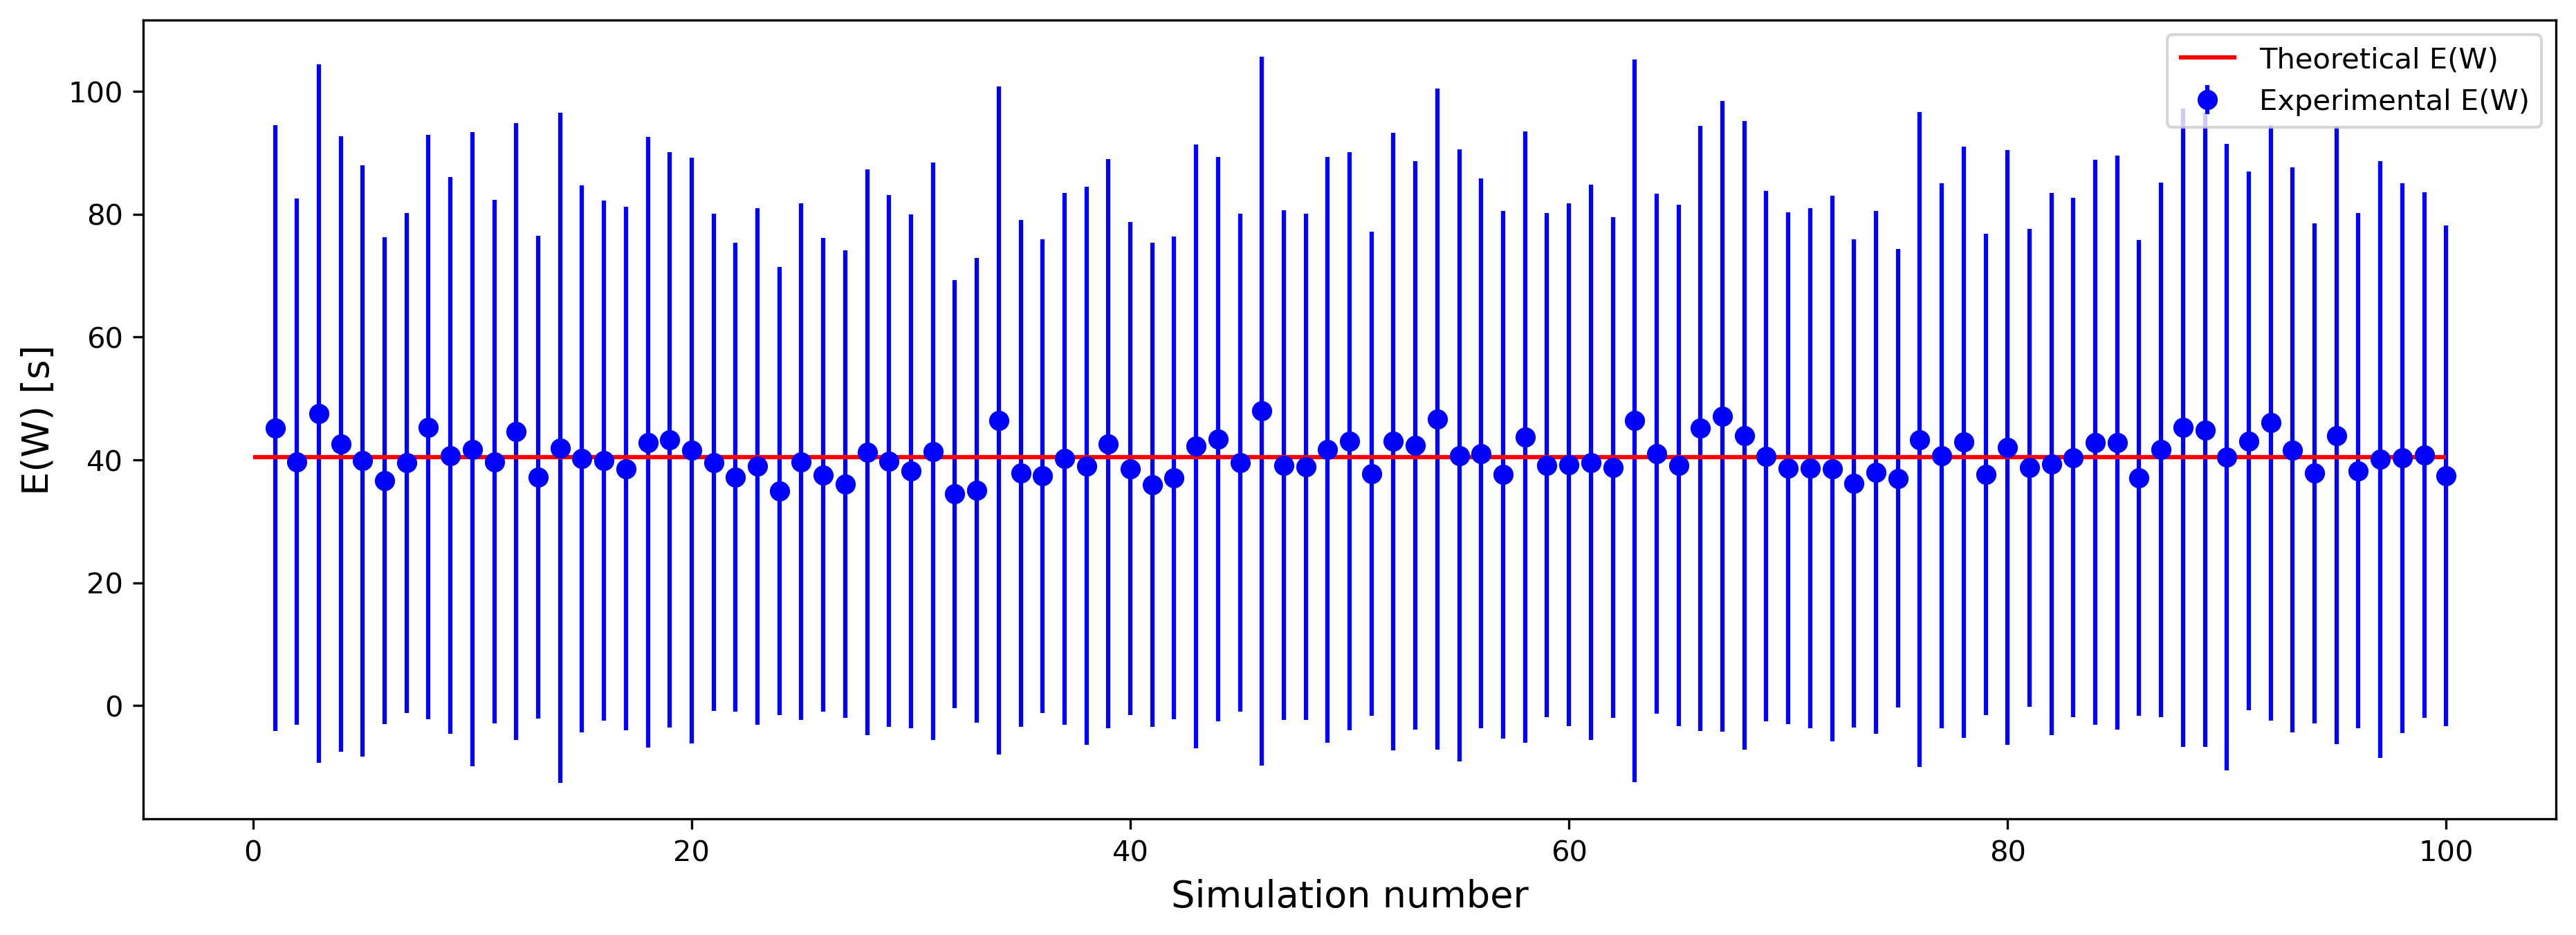

In [24]:
plt.figure(figsize=(15,5))
plt.errorbar(x=range(1, 101), y=E_W, yerr=E_W_std, fmt='o', color='blue', label='Experimental E(W)')
plt.hlines(E_W_n1, xmin=0, xmax=100, color = 'red', label='Theoretical E(W)')
plt.xlabel('Simulation number', fontsize=13)
plt.ylabel('E(W) [s]', fontsize=13)
plt.legend()
plt.show()

In [36]:
customer_array = [500, 1000, 2500, 5000, 10000, 25000, 50000, 75000, 100000, 150000, 200000, 250000]
means = []
stds = []
for i in customer_array:
    E_Ws, E_W_std, E_W_n1 = simulate_queue(i, 1/5, 1/4.5, 1, 100, int(0.1*i))

    means.append(np.mean(E_Ws))
    stds.append(np.std(E_Ws))

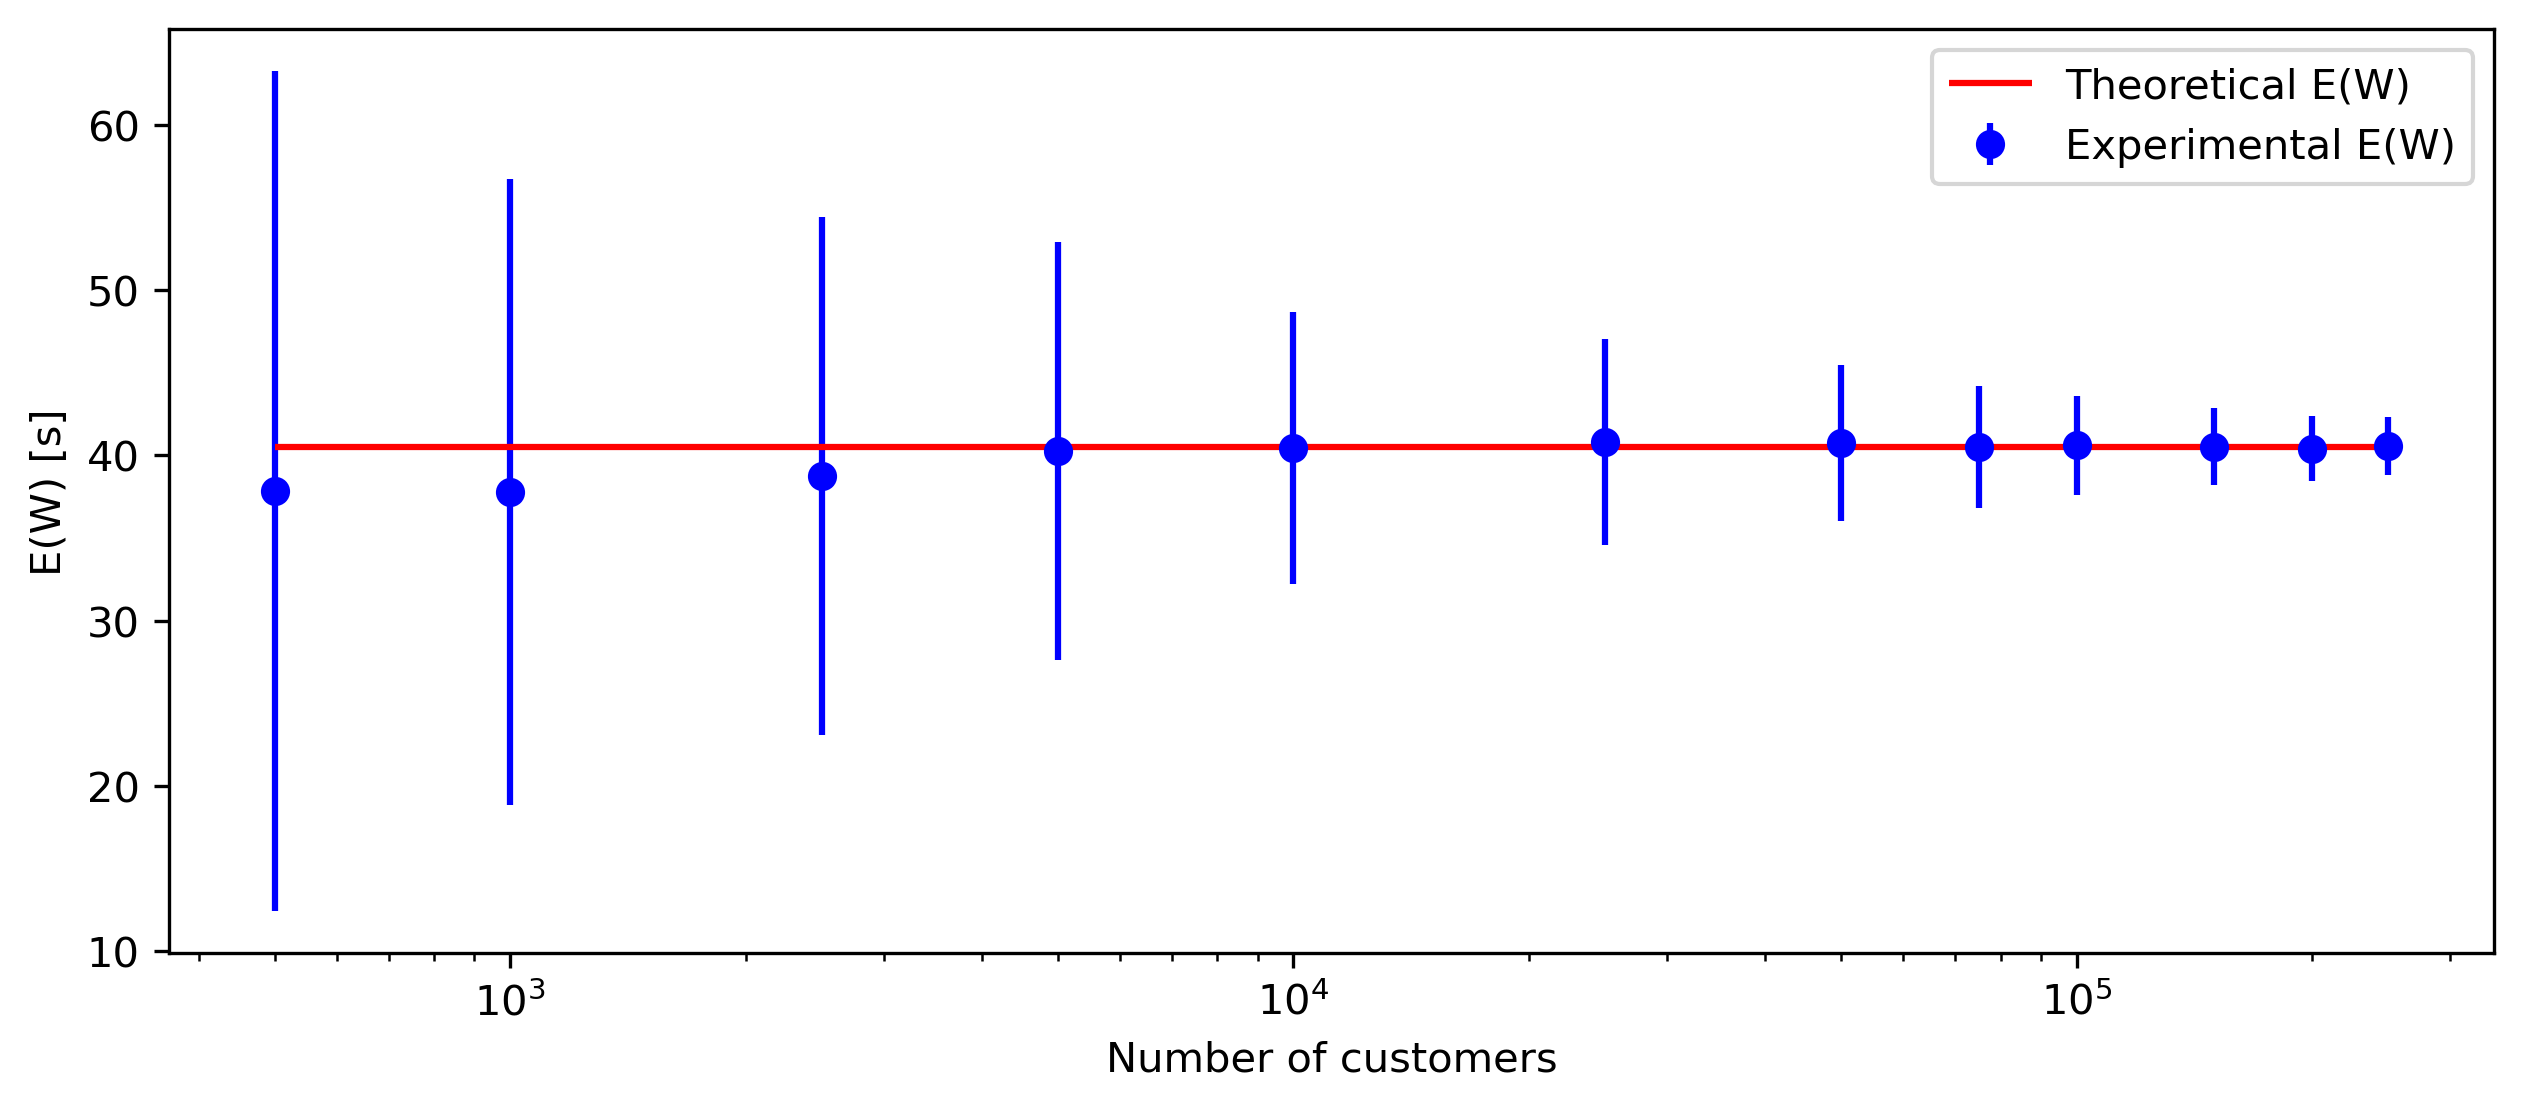

In [37]:
plt.figure(figsize=(10, 4))
plt.errorbar(x=customer_array, y=means, yerr=stds, fmt='o', color='blue', label='Experimental E(W)')
plt.hlines(E_W_n1, xmin=500, xmax=250000, color = 'red', label='Theoretical E(W)')
plt.ylabel('E(W) [s]')
plt.xlabel('Number of customers')
plt.xscale('log')
plt.legend()
plt.show()